In [1]:
import mosaic

from stride import *
from stride.utils import wavelets

%matplotlib notebook

In order to run the corresponding inverse problem, we also need to define a similar spatio-temporal grid and a `Problem`.

Then, our first step is to define this grid by creating a `Space` and `Time` objects that define the discretisation of our grid.

In [2]:
# Create the grid
shape = (356, 385)
extra = (50, 50)
absorbing = (40, 40)
spacing = (0.5e-3, 0.5e-3)

space = Space(shape=shape,
              extra=extra,
              absorbing=absorbing,
              spacing=spacing)

start = 0.
step = 0.08e-6
num = 2500

time = Time(start=start,
            step=step,
            num=num)

Based on this grid, we can define a `Problem`. In stride, a `Problem` object encapsulates all the information that is needed to describe a tomography experiment.

In its most basic form, the problem is given a name and the grid we have just created:

In [3]:
# Create problem
problem = Problem(name='anastasio2D',
                  space=space, time=time)

We can now start defining each of the components of the `Problem`.

Firstly, we need to define the physical properties that describe the medium in which our experiment is taking place.

Because we are going to run the default isotropic acoustic wave equation with constant density, we only need to define the longitudinal speed of sound of our medium. The longitudinal speed of sound is a scalar field, for which we can use the class `ScalarField`:

In [4]:
# Create medium
# Field(..., grid=problem.grid) is equivalent to Field(..., space=space, time=time)
vp = ScalarField('vp', grid=problem.grid)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous, with a value of 1500 m/s.

Next, we need to define the types of ultrasound transducers that we will use.

Because we are happy with using omnidirectional point sources and receivers, we can configure the default transducers:

In [5]:
# Create transducers
problem.transducers.default()

In order to use the transducers in our ultrasound acquisition, we need to add them to a `Geometry`. The `Geometry` defines the spatial location of each transducer within our grid.

In this case, we will generate a default elliptical geometry with 128 locations for our point transducers:

In [6]:
# Create geometry
num_locations = 128
problem.geometry.default('elliptical', num_locations)

Finally, we need to define what transducers in the geometry act as sources or as receivers. We do this by defining the `Acquisition`.

Because we have already saved our `Acquisition` as the output of the forward problem, we can simply reload it here instead of defining it again. The loaded information will contain the `Shot`s, the source excitations, and the observed data that is generated by the forward run.

In [7]:
# Create acquisitions
problem.acquisitions.load(path=problem.output_folder,
                          project_name=problem.name, version=0)

Once complete, we can review our `Problem` by plotting its components:

<IPython.core.display.Javascript object>


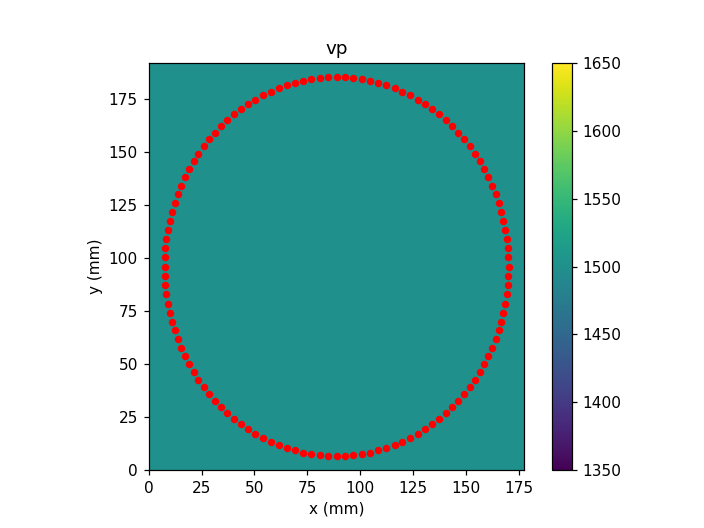

<IPython.core.display.Javascript object>


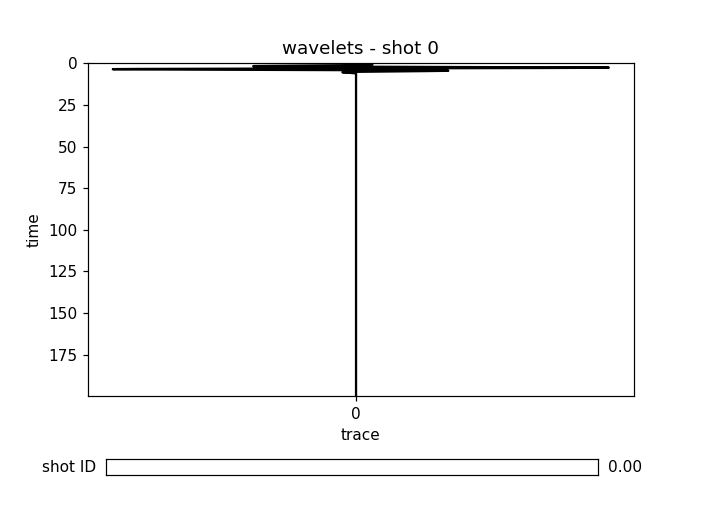

<IPython.core.display.Javascript object>


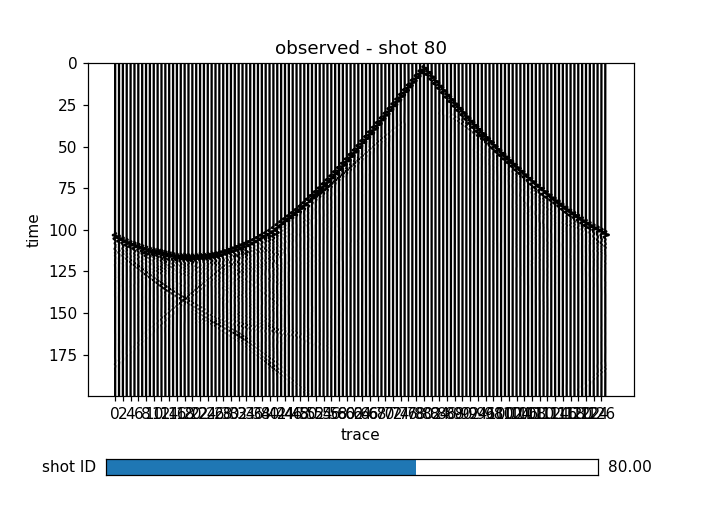

In [8]:
# Plot
problem.plot()

At this point, we have to define the image reconstruction process by creating an object of type `Optimisation`.

In [9]:
# Create optimisation object
optimisation = Optimisation()

We are interested in reconstructing the speed of sound of the medium, so we can create a corresponding optimisation variable that will be updated during the optimisation:

In [10]:
# Create optimisation variable
optim_vp = Vp('vp', grid=problem.grid)
optim_vp.extended_data[:] = vp.extended_data[:]

Lastly, we define an optimiser to update the variable.

In this case, we choose gradient descent with a constant step size:

In [11]:
# Create optimiser
step_size = 10
optimiser = GradientDescent(optim_vp, step=step_size)

optimisation.add(optim_vp, optimiser)

Before we start executing our inversion, we need to start up the mosaic runtime:

In [12]:
await mosaic.interactive('on')

2021-03-15 13:37:14,930 - INFO       HEAD            Listening at <CommsManager object at 139895990762256, uid=head, address=155.198.98.57, port=3000, state=listening>
2021-03-15 13:37:14,964 - INFO       MONITOR         Listening at <CommsManager object at 139895992624208, uid=monitor, address=155.198.98.57, port=3001, state=listening>
2021-03-15 13:37:15,007 - INFO       NODE:0          Listening at <CommsManager object at 139895973688464, uid=node:0, address=155.198.98.57, port=3002, state=listening>
2021-03-15 13:37:15,057 - INFO       WORKER:0:0      Listening at <CommsManager object at 139895973688720, uid=worker:0:0, address=155.198.98.57, port=3003, state=listening>


Now, we are ready to execute the problem.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 16 shots will be used for each iteration, and they will be selected randomly without replacement.

In [ ]:
# Run optimisation
max_freqs = [0.3e6, 0.4e6, 0.5e6, 0.6e6]

for freq, block in zip(max_freqs, optimisation.blocks(4)):
    block.config(num_iterations=8,
                 f_min=0.05e6, f_max=freq,
                 min=1400., max=1700.,
                 select_shots={'num': 16, 'randomly': True})

    await optimisation.run(block, problem)

Before closing, we should tear down the mosaic runtime.

In [14]:
await mosaic.interactive('off')